In [1]:
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pandas as pd
import numpy as np
import warnings
import optuna
import pickle

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
SEED = 27
N_SPLITS = 5
N_REPEATS = 1

# Loading the Dataset

In [3]:
train = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/flood-prediction-precomputed-stat-features/test.csv', index_col='id')

In [4]:
feats_to_drop = [
    '_sort_6', '_cnt17', 'Deforestation', 'Watersheds', '_std', '_cnt1', '_cnt12', 
    '_cnt16', '_cnt8', '_sort_9', 'RiverManagement', 'Encroachments', '_30th', '_10th', 
    '_min', 'DrainageSystems', '_sort_7', '_40th', '_sort_5', 'PoliticalFactors', 
    'ClimateChange', '_mode', 'Landslides', 'TopographyDrainage', 'PopulationScore'
]
train = train.drop(columns=feats_to_drop)
test = test.drop(columns=feats_to_drop)

In [5]:
train.shape, test.shape

((1117957, 65), (745305, 64))

In [6]:
target_col = 'FloodProbability'

X = train.drop(target_col, axis=1)
y = train[target_col]

# Training

In [7]:
class Trainer:
    def __init__(self, model, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [8]:
xgb_params = {
    'n_jobs': -1,
    'max_depth': 15,
    'max_leaves': 51,
    'n_estimators': 921,
    'random_state': SEED,
    'objective': 'reg:gamma',
    'grow_policy': 'depthwise',
    'gamma': 0.001191175583365525,
    'reg_alpha': 0.4922409840555407,
    'subsample': 0.9043911969552909,
    'reg_lambda': 0.2006103666827618,
    'max_delta_step': 0.5187236006765079,
    'learning_rate': 0.031068537109748533,
    'colsample_bynode': 0.9056076202576685,
    'min_child_weight': 0.1519636306480494,
    'colsample_bytree': 0.8136171314595549,
    'colsample_bylevel': 0.8469915838866402,
}

cb_params = {
    'depth': 10,
    'verbose': False,
    'iterations': 1566,
    'random_state': SEED,
    'min_data_in_leaf': 17,
    'loss_function': 'RMSE',
    'bootstrap_type': 'MVS',
    'grow_policy': 'SymmetricTree',
    'l2_leaf_reg': 1.6916966756596432,
    'learning_rate': 0.02548238769955287,
    'colsample_bylevel': 0.9626458989963868,
}

lgbm_params = {
    'n_jobs': -1,
    'verbose': -1,
    'max_depth': 34,
    'num_leaves': 171,
    'subsample_freq': 6,
    'n_estimators': 752,
    'random_state': SEED,
    'min_child_samples': 130,
    'subsample': 0.9350984753719289,
    'reg_alpha': 1.0394550805235323e-08,
    'reg_lambda': 4.033907925696443e-06,
    'learning_rate': 0.012066643395436406,
    'colsample_bytree': 0.7982322920102747,
    'min_child_weight': 0.002429931199773121
}

hgb_params = {
    "max_iter": 990,
    "max_depth": 8,
    "max_bins": 185,
    'random_state': SEED,
    "max_leaf_nodes": 183,
    "min_samples_leaf": 12,
    "learning_rate": 0.037434436270854445,
    "l2_regularization": 0.02286490401368979,
}

gb_params = {
    "max_depth": 9,
    "n_estimators": 369,
    'random_state': SEED,
    "alpha": 0.878238743008556,
    "subsample": 0.8110202065754267,
    "max_features": 0.3357955633913219,
    "learning_rate": 0.015631610015319746,
}

In [9]:
def train_regressor(regressor):
    trainer = Trainer(regressor, X, y)
    scores, oof_preds = trainer.fit()
    
    oof_preds_filename = f"{regressor.__class__.__name__.lower()}_oof_preds.pkl"
    with open(oof_preds_filename, 'wb') as f:
        pickle.dump(oof_preds, f)
    
    test_preds = trainer.predict(test)  
    test_preds_filename = f"{regressor.__class__.__name__.lower()}_test_preds.pkl"
    with open(test_preds_filename, 'wb') as f:
        pickle.dump(test_preds, f)
    
    print(f'{regressor.__class__.__name__}: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
    return scores, oof_preds, test_preds

xgb_model = XGBRegressor(**xgb_params)
xgb_scores, xgb_oof_preds, xgb_test_preds = train_regressor(xgb_model)

cb_model = CatBoostRegressor(**cb_params)
cb_scores, cb_oof_preds, cb_test_preds = train_regressor(cb_model)

lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_scores, lgbm_oof_preds, lgbm_test_preds = train_regressor(lgbm_model)

hgb_model = HistGradientBoostingRegressor(**hgb_params)
hgb_scores, hgb_oof_preds, hgb_test_preds = train_regressor(hgb_model)

gb_model = GradientBoostingRegressor(**gb_params)
gb_scores, gb_oof_preds, gb_test_preds = train_regressor(gb_model)

XGBRegressor: 0.869192 ± 0.000379
CatBoostRegressor: 0.869156 ± 0.000386
LGBMRegressor: 0.869302 ± 0.000365
HistGradientBoostingRegressor: 0.869165 ± 0.000397
GradientBoostingRegressor: 0.869295 ± 0.000384


In [10]:
_x = np.column_stack([
    xgb_oof_preds,
    cb_oof_preds, 
    lgbm_oof_preds,
    hgb_oof_preds, 
    gb_oof_preds
])

scaler = StandardScaler()
_x = pd.DataFrame(scaler.fit_transform(_x))

In [11]:
ridge = Ridge(positive=True, tol=1e-6).fit(_x, y)
ridge_preds = ridge.predict(_x)
ridge_score = r2_score(y, ridge_preds)
print(f'{ridge.__class__.__name__}: {ridge_score:.6f}')

ridge_2 = Ridge(positive=False, tol=1e-6).fit(_x, y)
ridge_2_preds = ridge_2.predict(_x)
ridge_2_score = r2_score(y, ridge_2_preds)
print(f'{ridge_2.__class__.__name__}2: {ridge_2_score:.6f}')

ridge_cv = RidgeCV().fit(_x, y)
ridge_cv_preds = ridge_cv.predict(_x)
ridge_cv_score = r2_score(y, ridge_cv_preds)
print(f'{ridge_cv.__class__.__name__}: {ridge_cv_score:.6f} (alpha:{ridge_cv.alpha_})')

lasso = Lasso(alpha=1e-6).fit(_x, y)
lasso_preds = lasso.predict(_x)
lasso_score = r2_score(y, lasso_preds)
print(f'{lasso.__class__.__name__}: {lasso_score:.6f}')

lasso_cv = LassoCV().fit(_x, y)
lasso_cv_preds = lasso_cv.predict(_x)
lasso_cv_score = r2_score(y, lasso_cv_preds)
print(f'{lasso_cv.__class__.__name__}: {lasso_cv_score:.6f} (alpha:{lasso_cv.alpha_})')

Ridge: 0.869388
Ridge2: 0.869388
RidgeCV: 0.869388 (alpha:10.0)
Lasso: 0.869258
LassoCV: 0.869258 (alpha:4.7574965288597205e-05)


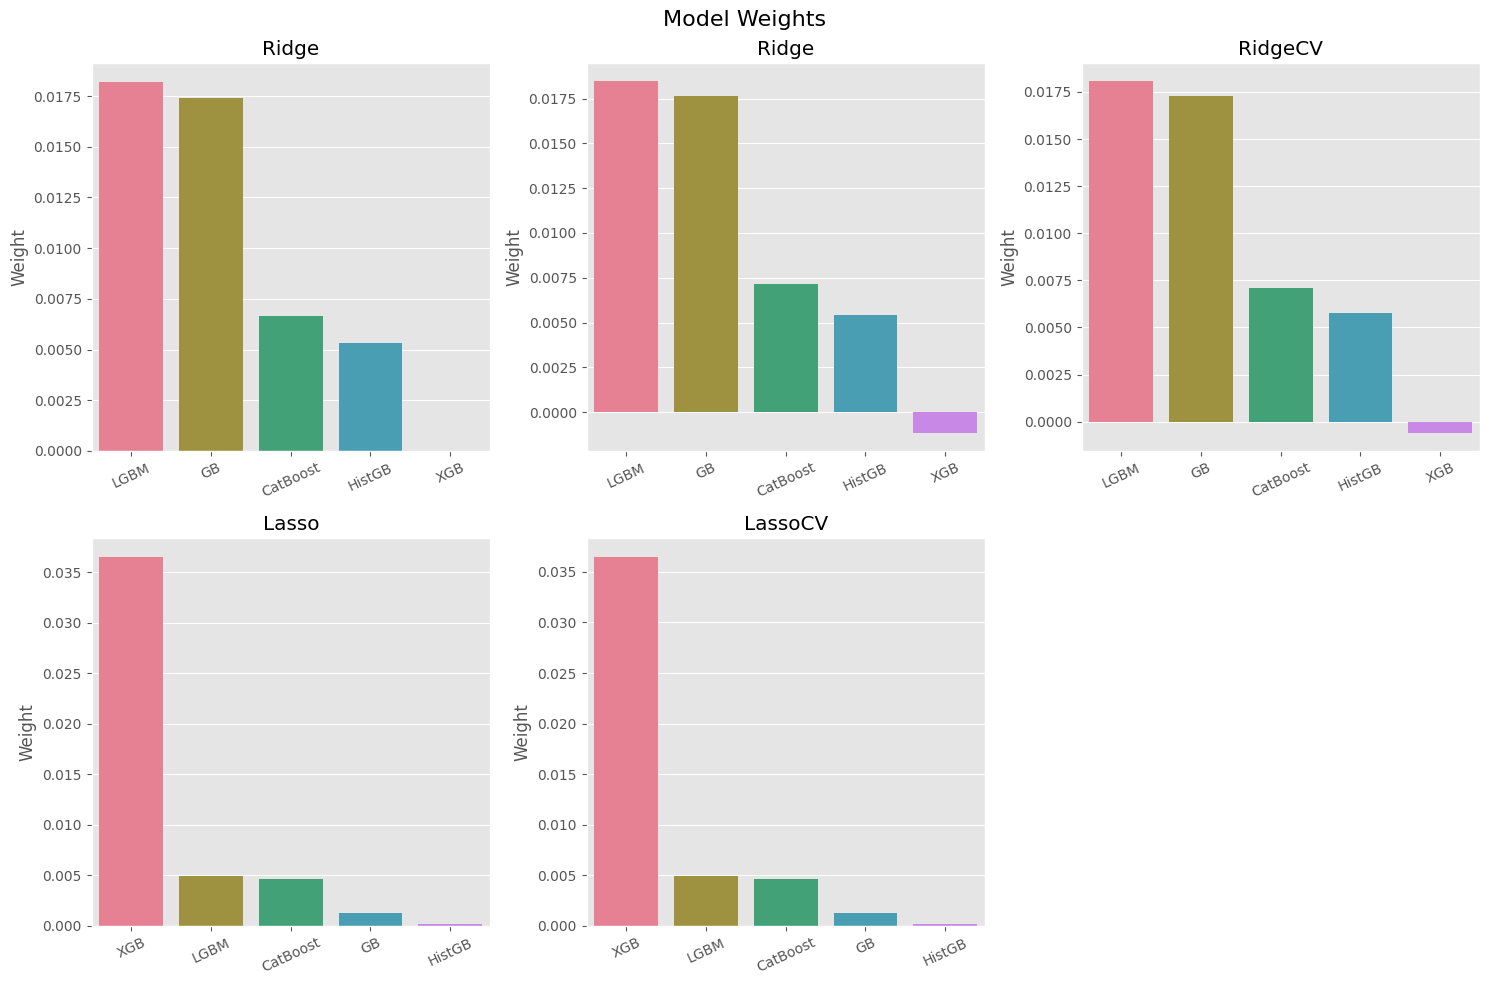

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

models = [ridge, ridge_2, ridge_cv, lasso, lasso_cv]
model_names = [
    "XGB",
    "CatBoost",
    "LGBM", 
    "HistGB", 
    "GB"
]

for ax, model in zip(axes.flatten(), models):
    weights = pd.Series(model.coef_, index=model_names).sort_values(ascending=False)
    sns.barplot(x=weights.index, y=weights.values, ax=ax, palette='husl')
    ax.set_title(f"{model.__class__.__name__}")
    ax.set_ylabel("Weight")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25)

fig.delaxes(axes.flatten()[-1])
fig.suptitle('Model Weights', fontsize=16)

plt.tight_layout()
plt.show()

In [13]:
for model in [ridge, ridge_2, ridge_cv, lasso, lasso_cv]:
    weights = pd.Series(
        model.coef_, 
        index=[
            "XGBRegressor",
            "CatBoostRegressor",
            "LGBMRegressor", 
            "HistGradientBoostingRegressor", 
            "GradientBoostingRegressor"
        ]
    )
    print(f"----------------- {model.__class__.__name__} -----------------")
    print(weights)
    print(f"\nSum: {np.sum(weights)}\n\n")

----------------- Ridge -----------------
XGBRegressor                     0.000000
CatBoostRegressor                0.006638
LGBMRegressor                    0.018204
HistGradientBoostingRegressor    0.005316
GradientBoostingRegressor        0.017423
dtype: float64

Sum: 0.04758028857651842


----------------- Ridge -----------------
XGBRegressor                    -0.001171
CatBoostRegressor                0.007177
LGBMRegressor                    0.018480
HistGradientBoostingRegressor    0.005452
GradientBoostingRegressor        0.017643
dtype: float64

Sum: 0.047580269966029015


----------------- RidgeCV -----------------
XGBRegressor                    -0.000621
CatBoostRegressor                0.007103
LGBMRegressor                    0.018085
HistGradientBoostingRegressor    0.005741
GradientBoostingRegressor        0.017270
dtype: float64

Sum: 0.047580190697010694


----------------- Lasso -----------------
XGBRegressor                     0.036528
CatBoostRegressor          

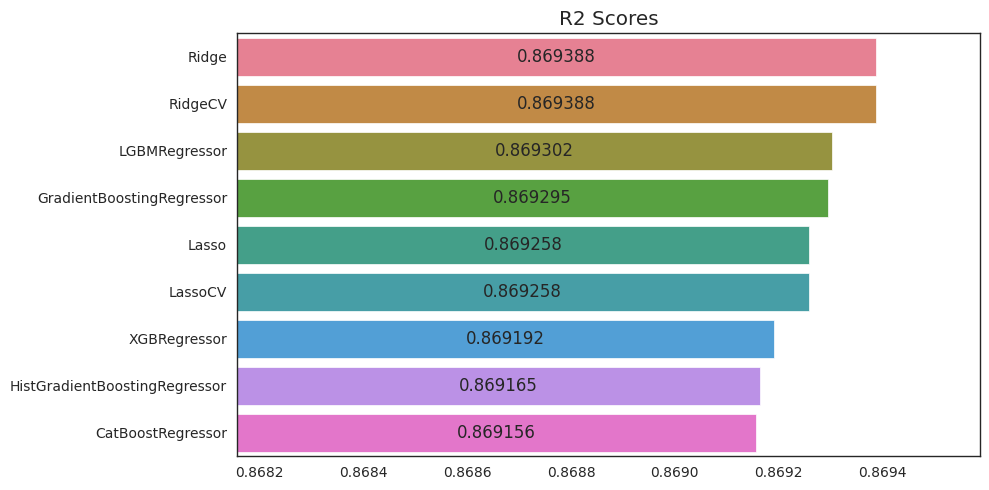

In [14]:
sns.set_style("white")
scores = pd.DataFrame({
    xgb_model.__class__.__name__: xgb_scores,
    cb_model.__class__.__name__: cb_scores,
    lgbm_model.__class__.__name__: lgbm_scores,
    hgb_model.__class__.__name__: hgb_scores,
    gb_model.__class__.__name__: gb_scores,
    ridge.__class__.__name__: np.array([ridge_score] * 5),
    ridge_2.__class__.__name__: np.array([ridge_2_score] * 5),
    ridge_cv.__class__.__name__: np.array([ridge_cv_score] * 5),
    lasso.__class__.__name__: np.array([lasso_score] * 5),
    lasso_cv.__class__.__name__: np.array([lasso_cv_score] * 5)
})
scores = scores[scores.mean().sort_values(ascending=False).index]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mean_scores = scores.mean().sort_values(ascending=False)
sns.barplot(x=mean_scores, y=mean_scores.index, orient='h', ax=ax, palette='husl')
ax.set_title('R2 Scores')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(mean_scores.min() - 0.001, mean_scores.max() + 0.0002)
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
model_preds = {
    xgb_model.__class__.__name__: xgb_oof_preds,
    cb_model.__class__.__name__: cb_oof_preds,
    lgbm_model.__class__.__name__: lgbm_oof_preds,
    hgb_model.__class__.__name__: hgb_oof_preds,
    gb_model.__class__.__name__: gb_oof_preds,
    ridge.__class__.__name__: ridge_preds
}

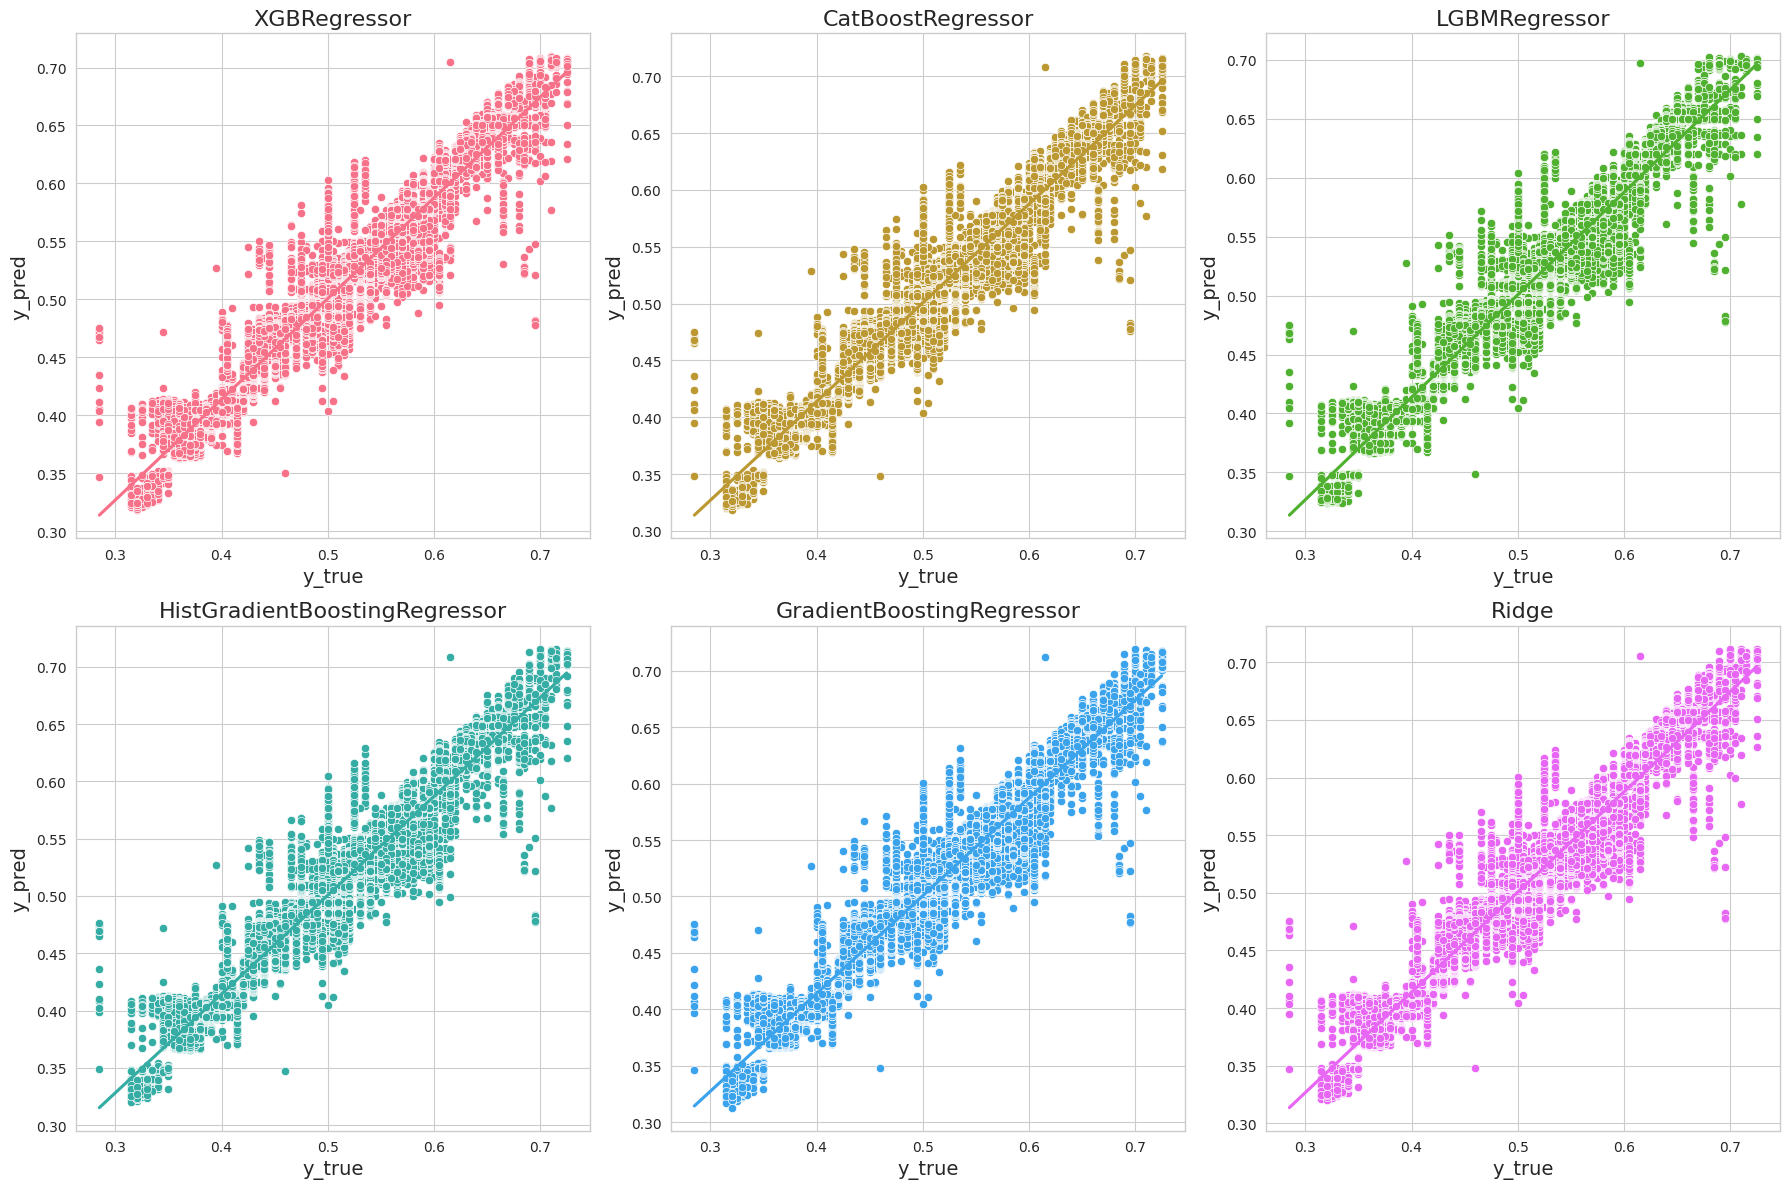

In [16]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    
    sns.scatterplot(x=y, y=preds, ax=ax, color=sns.color_palette("husl")[i])
    sns.regplot(x=y, y=preds, ax=ax, scatter=False, color=sns.color_palette("husl")[i])
    
    ax.set_xlabel('y_true', fontsize=14)
    ax.set_ylabel('y_pred', fontsize=14)
    ax.set_title(model, fontsize=16)

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

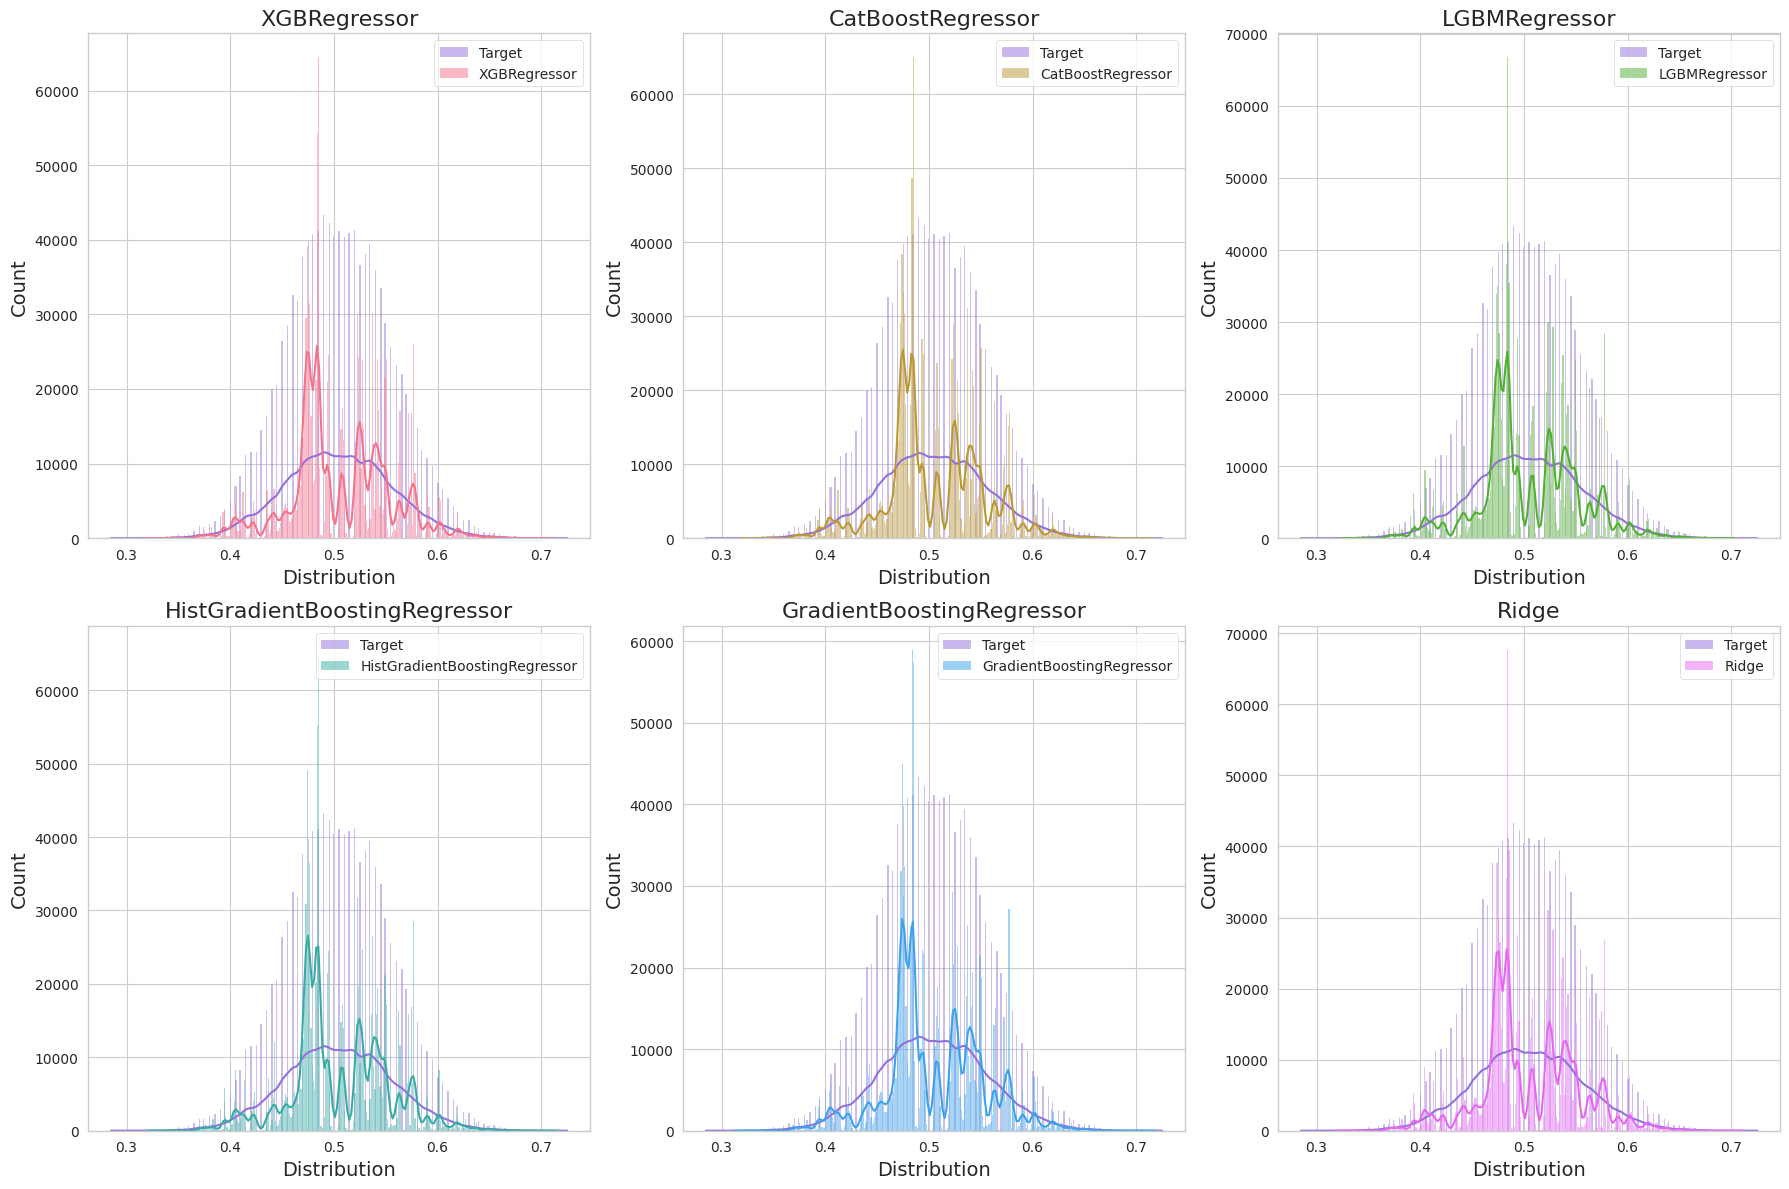

In [17]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    
    sns.histplot(data=y, ax=ax, color='#9370DB', kde=True, legend=True, label="Target")
    sns.histplot(data=preds, ax=ax, color=sns.color_palette("husl")[i], kde=True, legend=True, label=model)
    
    ax.set_xlabel('Distribution', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.set_title(model, fontsize=16)
    ax.legend()

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Making Predictions

In [18]:
ridge_x_test = np.column_stack([
    xgb_test_preds, 
    cb_test_preds,
    lgbm_test_preds, 
    hgb_test_preds, 
    gb_test_preds, 
])
scaler = StandardScaler()
ridge_x_test = pd.DataFrame(scaler.fit_transform(ridge_x_test))

In [19]:
y_pred = ridge.predict(ridge_x_test)
submission = pd.DataFrame({'id': test.index, target_col: y_pred})
submission.to_csv(f'ensemble.csv', index=False)
submission.head()

,id,FloodProbability
0,1117957,0.578079
1,1117958,0.456508
2,1117959,0.448832
3,1117960,0.466456
4,1117961,0.466275
